In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import getpass
pd.options.mode.chained_assignment = None

In [2]:
# Ruta para pcs
user = getpass.getuser() # Capturo el usuario local / Ejemplo "Llan_", este es el nombre de mi usuario que inicie sesion en la pc

if   user== "analistaup29": # PC Analista UP 29 Minedu
     work = Path(r"C:\Users\ANALISTAUP29\OneDrive - Ministerio de Educación\MINEDU_2022\RACIO")
elif user== "llan_": # PC casa Llan
     work = Path(r"C:\Users\llan_\OneDrive - Ministerio de Educación\MINEDU_2022\RACIO")
elif user == "USUARIO": # @hugoferquiroz casa
     work =  Path(r'D:\\Trabajo\AITeacherAllocation') 

In [3]:
df = pd.read_csv(work/r'Results\\Base consolidada.csv')
df.set_index(['cod_mod','year'],inplace=True)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_27760\3606240390.py:1: DtypeWarning: Columns (1,122) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(work/r'Results\\Base consolidada.csv')


# Target population

The goal is predict teacher allocation in this population target:

- Educational stage
    - Kindergarten 
    - Primary school

- Teachers:
    - Teachers
    - Education Assistant

- Type of school 
    - Public managed by Central Goverment

In [4]:
# Relevant rows
df = df.loc[df['niv_mod']!='F0'] # Educational stage
df = df.dropna(subset=['region']) # Drop missing in region
df = df.loc[(df['gestion']==1) & (df['ges_dep']=='A1')] # Type of school
df = df.loc[df['estado']==1] # Active in 2022

In [5]:
# Repair educational stage
df.loc[df['d_niv_mod']=='Inicial - Jard¡n','d_niv_mod'] = 'Inicial - Jardin'
df.loc[df['d_niv_mod']=='Inicial - Cuna-jard¡n','d_niv_mod'] = 'Inicial - Cuna-jardin'
# Drop few observations 
df = df.loc[df['d_niv_mod']!='Inicial - Cuna'] # 39 rows deleted
# Drop no relevant information in target variable
df = df.loc[df['secciones_necesarias']!=0] #720 rows deleted

In [6]:
df = df.loc[(df['doc_aula_req']!=0) | (df['doc_aula_exd_n']+df['doc_aula_exd_c']!=0)]

# Data for clusters
Divede the data for educational stage beacuse our objective is identify groups by educational stage

In [7]:
df['d_niv_mod'].value_counts()

Primaria                 22650
Inicial - Jardin         10388
Inicial - Cuna-jardin      251
Name: d_niv_mod, dtype: int64

In [8]:
def drop_no_relevant(df):
    '''
    Drop no relevant columns
    df: 
        - type: data frame
    '''
    df = df.drop(columns=['Unnamed: 0.1','usuario_minedu','bolsa_nexus','bolsa_sira',
'dir_req', 'sub_dir_req','jer_req','fisica_req','aip_req','dir_exd','sub_dir_exd',
'jer_exd','niv_mod','gestion','d_gestion','ges_dep','d_ges_dep','estado',
'd_estado','d_region','tipo_entidad','jec','Unnamed: 0','otro_doc_exd','d_dpto','codlocal','d_dist','d_niv_mod',]) 
    df['doc_exd']= df['doc_aula_exd_n']+df['doc_aula_exd_c']
    df = df.drop(columns=['doc_aula_exd_n', 'doc_aula_exd_c'])
    return df

## Primary level

In [9]:
# Primary
df_primaria = df.loc[df['d_niv_mod']=='Primaria']
df_primaria = drop_no_relevant(df_primaria)
# Enrollment in primary is 1 - 6
enrolment_no_primary = [ x for x in df_primaria.columns.to_list() if (x.find('cant0')!=-1) | (x.find('inclu0')!=-1) ]
df_primaria = df_primaria.drop(columns=enrolment_no_primary)

In [10]:
num_primaria = [x for x in df_primaria.columns if (df_primaria[x].dtype == 'int64') | (df_primaria[x].dtype =='float64') ]
str_primaria = [x for x in df_primaria.columns if (df_primaria[x].dtype == 'object') ]

### Missing

In [11]:
df_primaria[['nlat_ie','nlong_ie']].isnull().sum()

nlat_ie     0
nlong_ie    0
dtype: int64

In [12]:
df_primaria[str_primaria].isnull().sum()

d_prov            0
d_dreugel         0
region            0
ruralidad         0
vraem             0
frontera          0
bilingue          0
caracteristica    0
dtype: int64

<AxesSubplot:ylabel='cod_mod-year'>

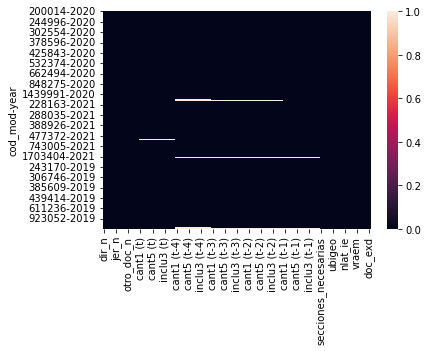

In [13]:
# Inspecting missing
import seaborn as sns
sns.heatmap(df_primaria.isnull())

In [14]:
# Imputing missing
df_primaria.fillna(0,inplace=True)

### Feature selection

#### Build total labor force and growth enrollment

In [15]:
# Labor force
df_primaria['Directores'] = df_primaria['dir_n'] + df_primaria['dir_c']
df_primaria['Subdirectores'] = df_primaria['sub_dir_n'] + df_primaria['sub_dir_c']
df_primaria['Jerarquicos'] = df_primaria['jer_n'] + df_primaria['jer_c']
df_primaria['Docentes de aula'] = df_primaria['doc_aula_n'] + df_primaria['doc_aula_c']
df_primaria['Otros docentes'] = df_primaria['otro_doc_n'] + df_primaria['otro_doc_c']
df_primaria['Auxiliares'] = df_primaria['aux_n'] + df_primaria['aux_c']
personal = ['Directores','Subdirectores','Jerarquicos','Docentes de aula','Otros docentes','Auxiliares']

In [16]:
# Enrollment
periodos = ['t','t-1','t-2','t-3','t-4']
# Total Enrollment
for i in periodos:
    df_primaria[f'Matricula regular total {i}']=df_primaria[f'cant1 ({i})']+df_primaria[f'cant2 ({i})']+df_primaria[f'cant3 ({i})']+df_primaria[f'cant4 ({i})']+df_primaria[f'cant5 ({i})']+df_primaria[f'cant6 ({i})']
    df_primaria[f'Matricula inclusiva total {i}']=df_primaria[f'inclu1 ({i})']+df_primaria[f'inclu2 ({i})']+df_primaria[f'inclu3 ({i})']+df_primaria[f'inclu4 ({i})']+df_primaria[f'inclu5 ({i})']+df_primaria[f'inclu6 ({i})']

# Growth rate enrollment
# Method 1
#df_primaria["tasa_c_anual_regular"]=((df_primaria['Matricula regular total t']/df_primaria['Matricula regular total t-4'])**(1/4))-1
#df_primaria["tasa_c_anual_inclusivo"]=((df_primaria['Matricula inclusiva total t']/df_primaria['Matricula inclusiva total t-4'])**(1/4))-1
# Method 2
df_primaria['tasa_c_anual_regular'] = ((df_primaria['Matricula regular total t']+df_primaria['Matricula regular total t-1'])+
                                        (df_primaria['Matricula regular total t-1']+df_primaria['Matricula regular total t-2'])+
                                        (df_primaria['Matricula regular total t-3']+df_primaria['Matricula regular total t-4']))/3

#### Scaling the input features

In [17]:
# Drop no relevant information
df_primaria.drop(columns=['aux_exd','aux_req','jer_n','aux_n','aux_c','dir_n','dir_c','sub_dir_n','sub_dir_c', 'jer_c', 'doc_aula_n', 'doc_aula_c', 'otro_doc_n', 'otro_doc_c'],inplace=True)

In [18]:
# Drop no relevant information for encoding
df_primaria.drop(columns=['d_prov','d_dreugel','region','caracteristica'],inplace=True)

In [19]:
# Requerimiento
primaria_req = df_primaria.loc[df_primaria['doc_aula_req']!=0]
primaria_req.drop(columns=['doc_exd'], inplace=True)
# Excedentes
primaria_exd = df_primaria.loc[df_primaria['doc_exd']!=0]
primaria_exd.drop(columns=['doc_aula_req'], inplace=True)

In [20]:
num_exd = [x for x in primaria_exd.columns if primaria_exd[x].dtype!='object']
num_req = [x for x in primaria_req.columns if primaria_req[x].dtype!='object']

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

primaria_exd_scaled = pd.DataFrame(scaler.fit_transform(primaria_exd[num_exd].values), columns=primaria_exd[num_exd].columns, index=primaria_exd[num_exd].index)
primaria_req_scaled = pd.DataFrame(scaler.fit_transform(primaria_req[num_req].values), columns=primaria_req[num_req].columns, index=primaria_req[num_req].index)

#### Encoding categorical variable

In [22]:
str_exd = [x for x in primaria_exd.columns if primaria_exd[x].dtype=='object']
str_req = [x for x in primaria_req.columns if primaria_req[x].dtype=='object']

In [23]:
def encoding_str(df, list_str):
    """Generate a new DataFrame with encoding string columns 

    Args:
        df (DataFrame): The original DataFrame
        list_str (List): List of string columns to encoding
    """
    new_df = pd.get_dummies(df[list_str])
    new_df.drop(columns=['frontera_No frontera', 'bilingue_No bilingue','vraem_No Vraem','ruralidad_Urbano'],inplace=True)
    return new_df

In [24]:
oh_prim_exd = pd.get_dummies(primaria_exd[str_exd])
oh_prim_req = pd.get_dummies(primaria_req[str_req])

In [25]:
# Join with the dataframe scaler
prim_exd_clean = pd.merge(left=primaria_exd_scaled ,right=oh_prim_exd,left_index=True,right_index=True)
prim_req_clean = pd.merge(left=primaria_req_scaled ,right=oh_prim_req,left_index=True,right_index=True)

### Finding optimal clusters

In [26]:
# Determino la cantidad de clusters
from sklearn.cluster import KMeans

In [27]:
primaria_req_knn = prim_req_clean.copy()
primaria_exd_knn = prim_exd_clean.copy()

Metodo 1: Visual

In [28]:
def visualizer_elbow(df,n_clusters=2,seed=36963):
    """_summary_

    Args:
        df (_type_): _description_
        n_clusters (int, optional): _description_. Defaults to 2.
        seed (int, optional): _description_. Defaults to 36963.
    """
    wcss = []
    for i in range(1,n_clusters):
        kmeans = KMeans(n_clusters=i,init='k-means++',random_state=seed)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        
    # Graficaremos lva evalución de la varianza intra-clusters
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
    ax.plot(range(1,n_clusters), wcss, marker='o')
    ax.set_title("Evolución de la varianza intra-cluster total")
    ax.set_xlabel('Número clusters')
    ax.set_ylabel('Intra-cluster (inertia)')
    my_elbow = plt.plot(range(1,n_clusters),wcss)

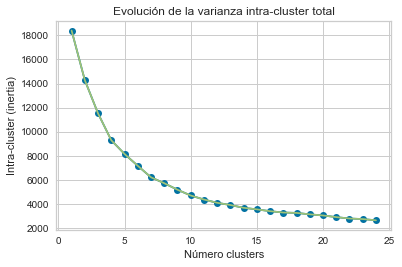

In [36]:
visualizer_elbow(primaria_req_knn,25)

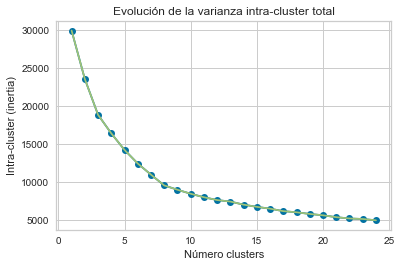

In [35]:
visualizer_elbow(primaria_exd_knn,25)

Metodo 2: Usar la libreria yellowbrick

In [ ]:
#pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

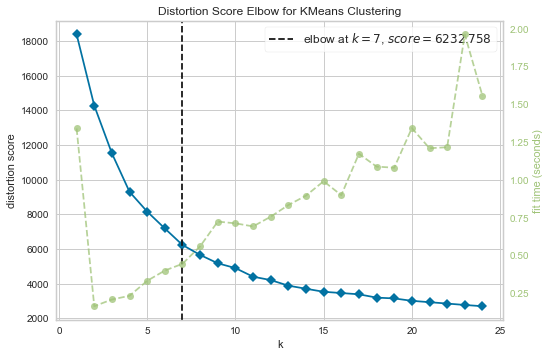

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [33]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,25))
visualizer.fit(primaria_req_knn)        
visualizer.show() 

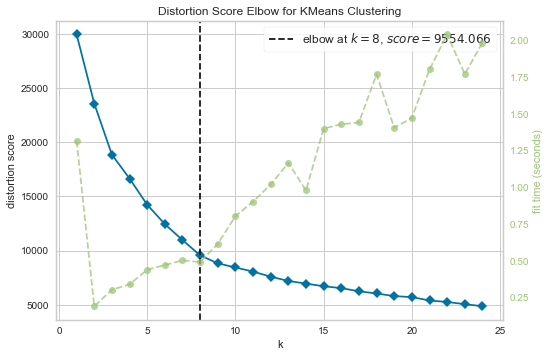

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [34]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,25))
visualizer.fit(primaria_exd_knn)        
visualizer.show() 

Resumen de los clusters optimos:
- Para requerimientos: 7 clusters
- Para excedentes: 8 clusters

In [66]:
def build_clusters(df_to_fit,n_clusters,df_original,random_state=36963):
    """Return a Data Frame with the column Clusters into the orginal DataFrame. This column indicate the number of clusters into the DataFrame

    Args:
        df_to_fit (DataFrame): The DataFrame to fit and predict
        n_clusters (Int): The numbers of clusters
        df_original (DataFrame): The DataFrame without scaling or encoding (The original DataFrame)
        random_state (Int): The seed to replicate
    """
    # Fit the model
    kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=random_state)
    kmeans.fit(df_to_fit)

    # Predict in the original sample
    clusters = kmeans.predict(df_to_fit)
    df_to_fit['Clusters'] = clusters

    # Include the clusters into original DataFrame
    df = pd.merge(left=df_original, right=df_to_fit[['Clusters']],  left_index=True , right_index=True)
    return df

In [67]:
df_req_prim_clusters = build_clusters(primaria_req_knn,7,primaria_req)
df_exd_prim_clusters = build_clusters(primaria_exd_knn,8,primaria_exd)

### Inspecting clusters

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Labor force

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


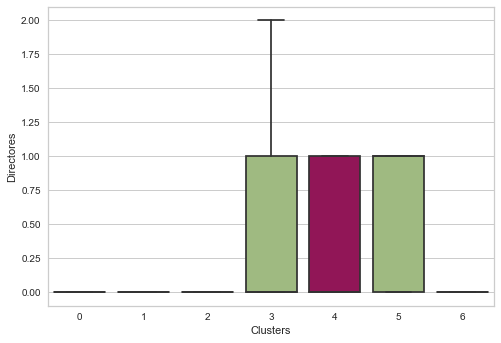

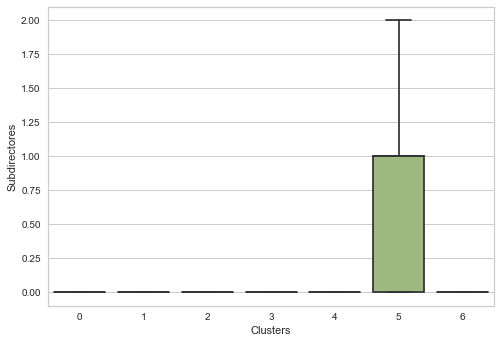

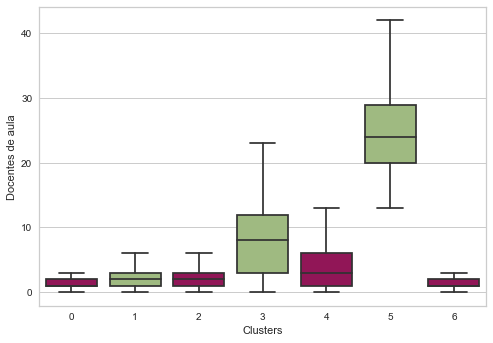

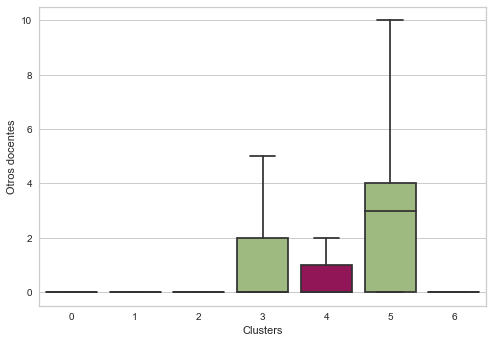

<Figure size 576x396 with 0 Axes>

In [84]:
for i in ['Directores', 'Subdirectores','Docentes de aula','Otros docentes']:
    print(sns.boxplot(x= 'Clusters', y=f'{i}', data=df_req_prim_clusters, palette=["m", "g"],showfliers = False))
    plt.figure()

#### Enrollment

In [ ]:
sns.boxplot(x='Clusters', y='tasa_c_anual_regular', palette=["m", "g"],
            data=df_req_prim_clusters,showfliers = False)

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


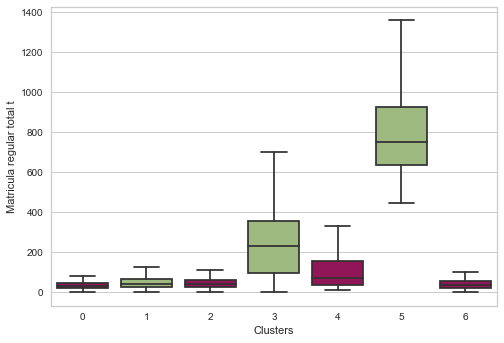

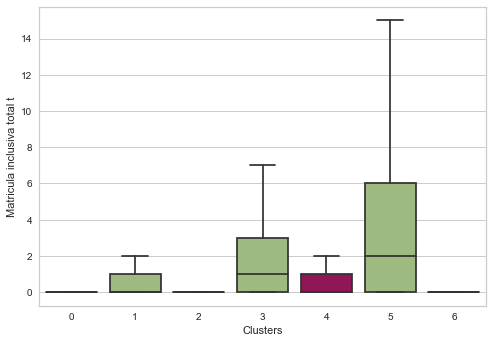

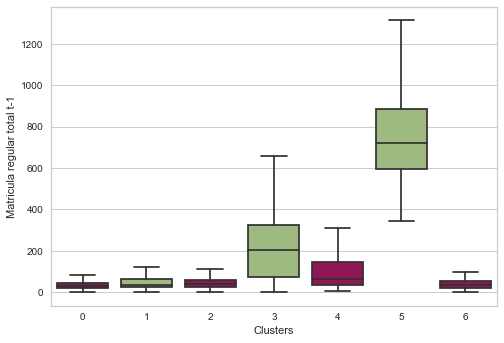

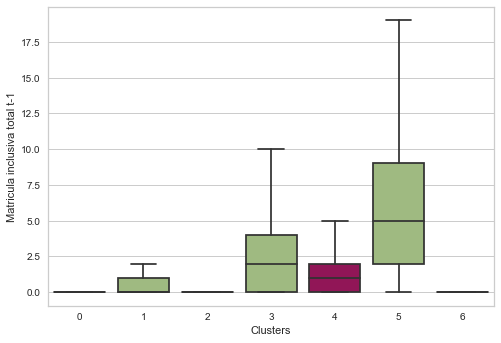

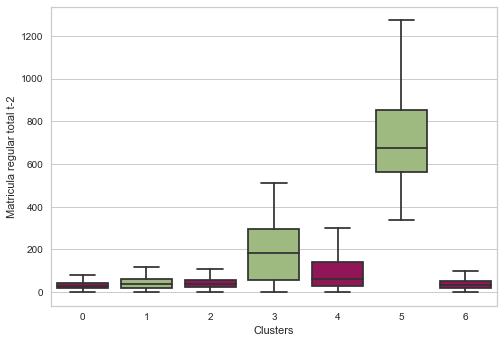

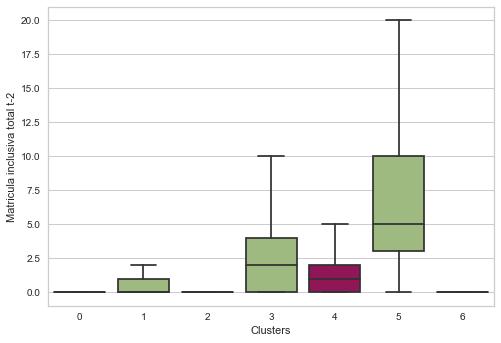

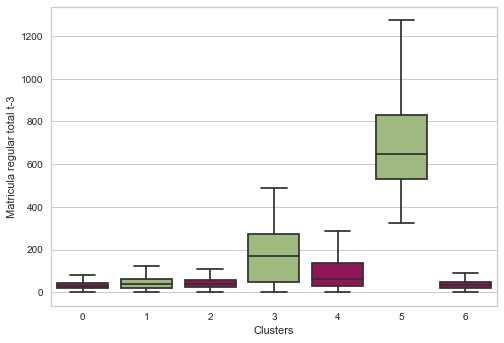

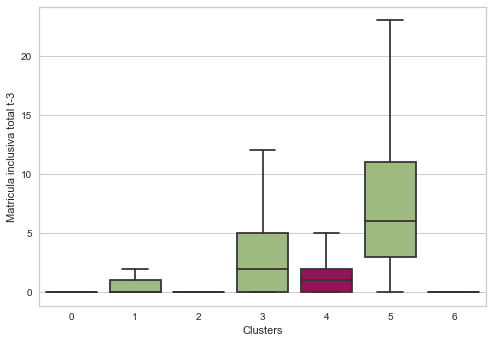

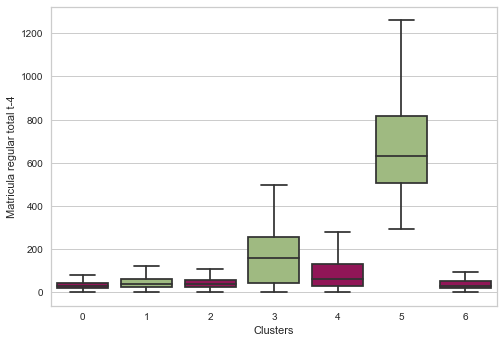

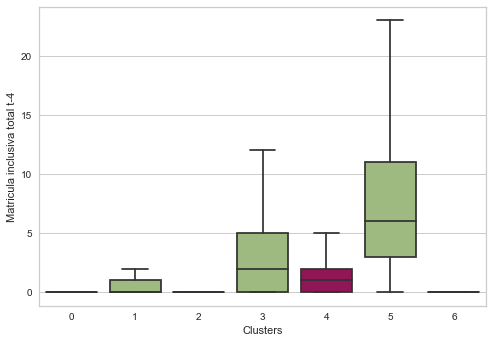

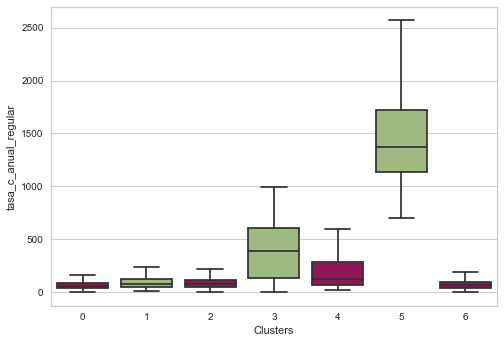

<Figure size 576x396 with 0 Axes>

In [87]:
enroll = ['Matricula regular total t', 'Matricula inclusiva total t',
            'Matricula regular total t-1','Matricula inclusiva total t-1',
            'Matricula regular total t-2','Matricula inclusiva total t-2',
            'Matricula regular total t-3','Matricula inclusiva total t-3',
            'Matricula regular total t-4','Matricula inclusiva total t-4',
            'tasa_c_anual_regular']

for i in enroll:
    print(sns.boxplot(x= 'Clusters', y=f'{i}', data=df_req_prim_clusters, palette=["m", "g"],showfliers = False))
    plt.figure()

#### Other features

In [69]:
for i in range(7):
    print(f'Cluster {i}')
    print(df_req_prim_clusters.loc[df_req_prim_clusters['Clusters']==i, ['Directores', 'Subdirectores','Jerarquicos','Docentes de aula','Otros docentes','Auxiliares']].describe().transpose())
    print('\n')

Cluster 0
                   count      mean       std  min  25%  50%  75%   max
Directores        2950.0  0.113559  0.317329  0.0  0.0  0.0  0.0   1.0
Subdirectores     2950.0  0.000678  0.026033  0.0  0.0  0.0  0.0   1.0
Jerarquicos       2950.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0
Docentes de aula  2950.0  1.735593  1.153196  0.0  1.0  1.0  2.0  18.0
Otros docentes    2950.0  0.036271  0.197577  0.0  0.0  0.0  0.0   2.0
Auxiliares        2950.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0


Cluster 1
                   count      mean       std  min  25%  50%  75%   max
Directores        1668.0  0.243405  0.429266  0.0  0.0  0.0  0.0   1.0
Subdirectores     1668.0  0.010791  0.103350  0.0  0.0  0.0  0.0   1.0
Jerarquicos       1668.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0
Docentes de aula  1668.0  2.559952  2.587753  0.0  1.0  2.0  3.0  24.0
Otros docentes    1668.0  0.119904  0.388820  0.0  0.0  0.0  0.0   3.0
Auxiliares        1668.0  0.000000  0.000000  0.0  0.0 

In [70]:
enroll = ['Matricula regular total t', 'Matricula inclusiva total t',
            'Matricula regular total t-1','Matricula inclusiva total t-1',
            'Matricula regular total t-2','Matricula inclusiva total t-2',
            'Matricula regular total t-3','Matricula inclusiva total t-3',
            'Matricula regular total t-4','Matricula inclusiva total t-4',
            'tasa_c_anual_regular']

for i in range(7):
    print(f'Cluster {i}')
    print(df_req_prim_clusters.loc[df_req_prim_clusters['Clusters']==i, enroll].describe().transpose())
    print('\n')

Cluster 0
                                count       mean        std       min  \
Matricula regular total t      2950.0  39.132542  27.099575  0.000000   
Matricula inclusiva total t    2950.0   0.328814   0.935174  0.000000   
Matricula regular total t-1    2950.0  36.994915  25.458088  0.000000   
Matricula inclusiva total t-1  2950.0   0.426102   1.472638  0.000000   
Matricula regular total t-2    2950.0  36.024068  24.893556  0.000000   
Matricula inclusiva total t-2  2950.0   0.431525   1.536894  0.000000   
Matricula regular total t-3    2950.0  35.161017  24.429264  0.000000   
Matricula inclusiva total t-3  2950.0   0.438644   1.523457  0.000000   
Matricula regular total t-4    2950.0  34.661017  24.286600  0.000000   
Matricula inclusiva total t-4  2950.0   0.421356   1.217491  0.000000   
tasa_c_anual_regular           2950.0  72.989492  49.088151  1.333333   

                                     25%        50%        75%         max  
Matricula regular total t      22.00

In [72]:
for i in range(6):
    print(f'Cluster {i}')
    print(df_req_prim_clusters.loc[df_req_prim_clusters['Clusters']==i, ['ruralidad','vraem', 'frontera','bilingue']].describe().transpose())
    print('\n')

Cluster 0
          count unique          top  freq
ruralidad  2950      1      Rural 1  2950
vraem      2950      2     No Vraem  2773
frontera   2950      1  No frontera  2950
bilingue   2950      1  No bilingue  2950


Cluster 1
          count unique          top  freq
ruralidad  1668      1      Rural 2  1668
vraem      1668      2     No Vraem  1616
frontera   1668      2  No frontera  1558
bilingue   1668      1  No bilingue  1668


Cluster 2
          count unique          top  freq
ruralidad  1455      4      Rural 1  1122
vraem      1455      2     No Vraem  1224
frontera   1455      1  No frontera  1455
bilingue   1455      1     Bilingue  1455


Cluster 3
          count unique          top  freq
ruralidad  1348      1       Urbano  1348
vraem      1348      2     No Vraem  1332
frontera   1348      2  No frontera  1309
bilingue   1348      2  No bilingue  1346


Cluster 4
          count unique          top freq
ruralidad   743      1      Rural 3  743
vraem       743     

In [ ]:
['dir_n','dir_c','sub_dir_n','sub_dir_c', 'jer_c', 'doc_aula_n', 'doc_aula_c', 'otro_doc_n', 'otro_doc_c']
['secciones_necesarias','doc_aula_req']
['Directores', 'Subdirectores','Jerarquicos','Docentes de aula','Otros docentes','Auxiliares']

['Matricula regular total t', 'Matricula inclusiva total t',
 'Matricula regular total t-1','Matricula inclusiva total t-1',
 'Matricula regular total t-2','Matricula inclusiva total t-2',
 'Matricula regular total t-3','Matricula inclusiva total t-3',
 'Matricula regular total t-4','Matricula inclusiva total t-4',
 'tasa_c_anual_regular']

['ruralidad_Rural 1','ruralidad_Rural 2','ruralidad_Rural 3','vraem_Vraem', 'frontera_Frontera','bilingue_Bilingue']